In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, rand,lit

In [2]:
spark = SparkSession.builder.appName("u_to_sb").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/29 02:30:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/29 02:30:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Part 1 : Done

In [6]:
shots = spark.read.csv("understat/understat.csv", header=True, inferSchema=True)
shots_sb = spark.read.csv("Data/Datas/shots.csv", header=True, inferSchema=True)

In [82]:
shots = shots.withColumnRenamed("regular_play", "from_rp")

In [7]:
FEATURES = ['from_rp','from_fk','from_corner',
            'header','corner_type','fk_type','pk_type',
            'acrobatic_shot','lob_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot',
            'shot_first_time','shot_one_on_one','shot_follows_dribble','players_inside_area']

In [12]:
features = ['header','fk_type','from_corner','from_rp','pk_type','distance_to_goal','shot_angle','preferred_foot_shot',
            'from_fk','shot_follows_dribble','shot_first_time','acrobatic_shot','shot_one_on_one','corner_type',
            'lob_technique','players_inside_area']

In [8]:
# check if the columns are in the dataframe
for feature in FEATURES:
    if feature not in shots.columns:
        print(f"Column {feature} not in dataframe")

In [9]:
shots_sb = shots_sb.withColumn('acrobatic_shot',
                    when((col('half_volley_technique')==1)
                         | (col('volley_technique')==1)
                         | (col('overhead_technique')==1),1).otherwise(0)).drop('half_volley_technique',
                                                                                'volley_technique',
                                                                                'overhead_technique')

In [10]:
p = shots_sb.drop('id','player_id','shot_location_x','shot_location_y','shot_outcome','sb_prediction').toPandas()

25/01/29 02:31:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


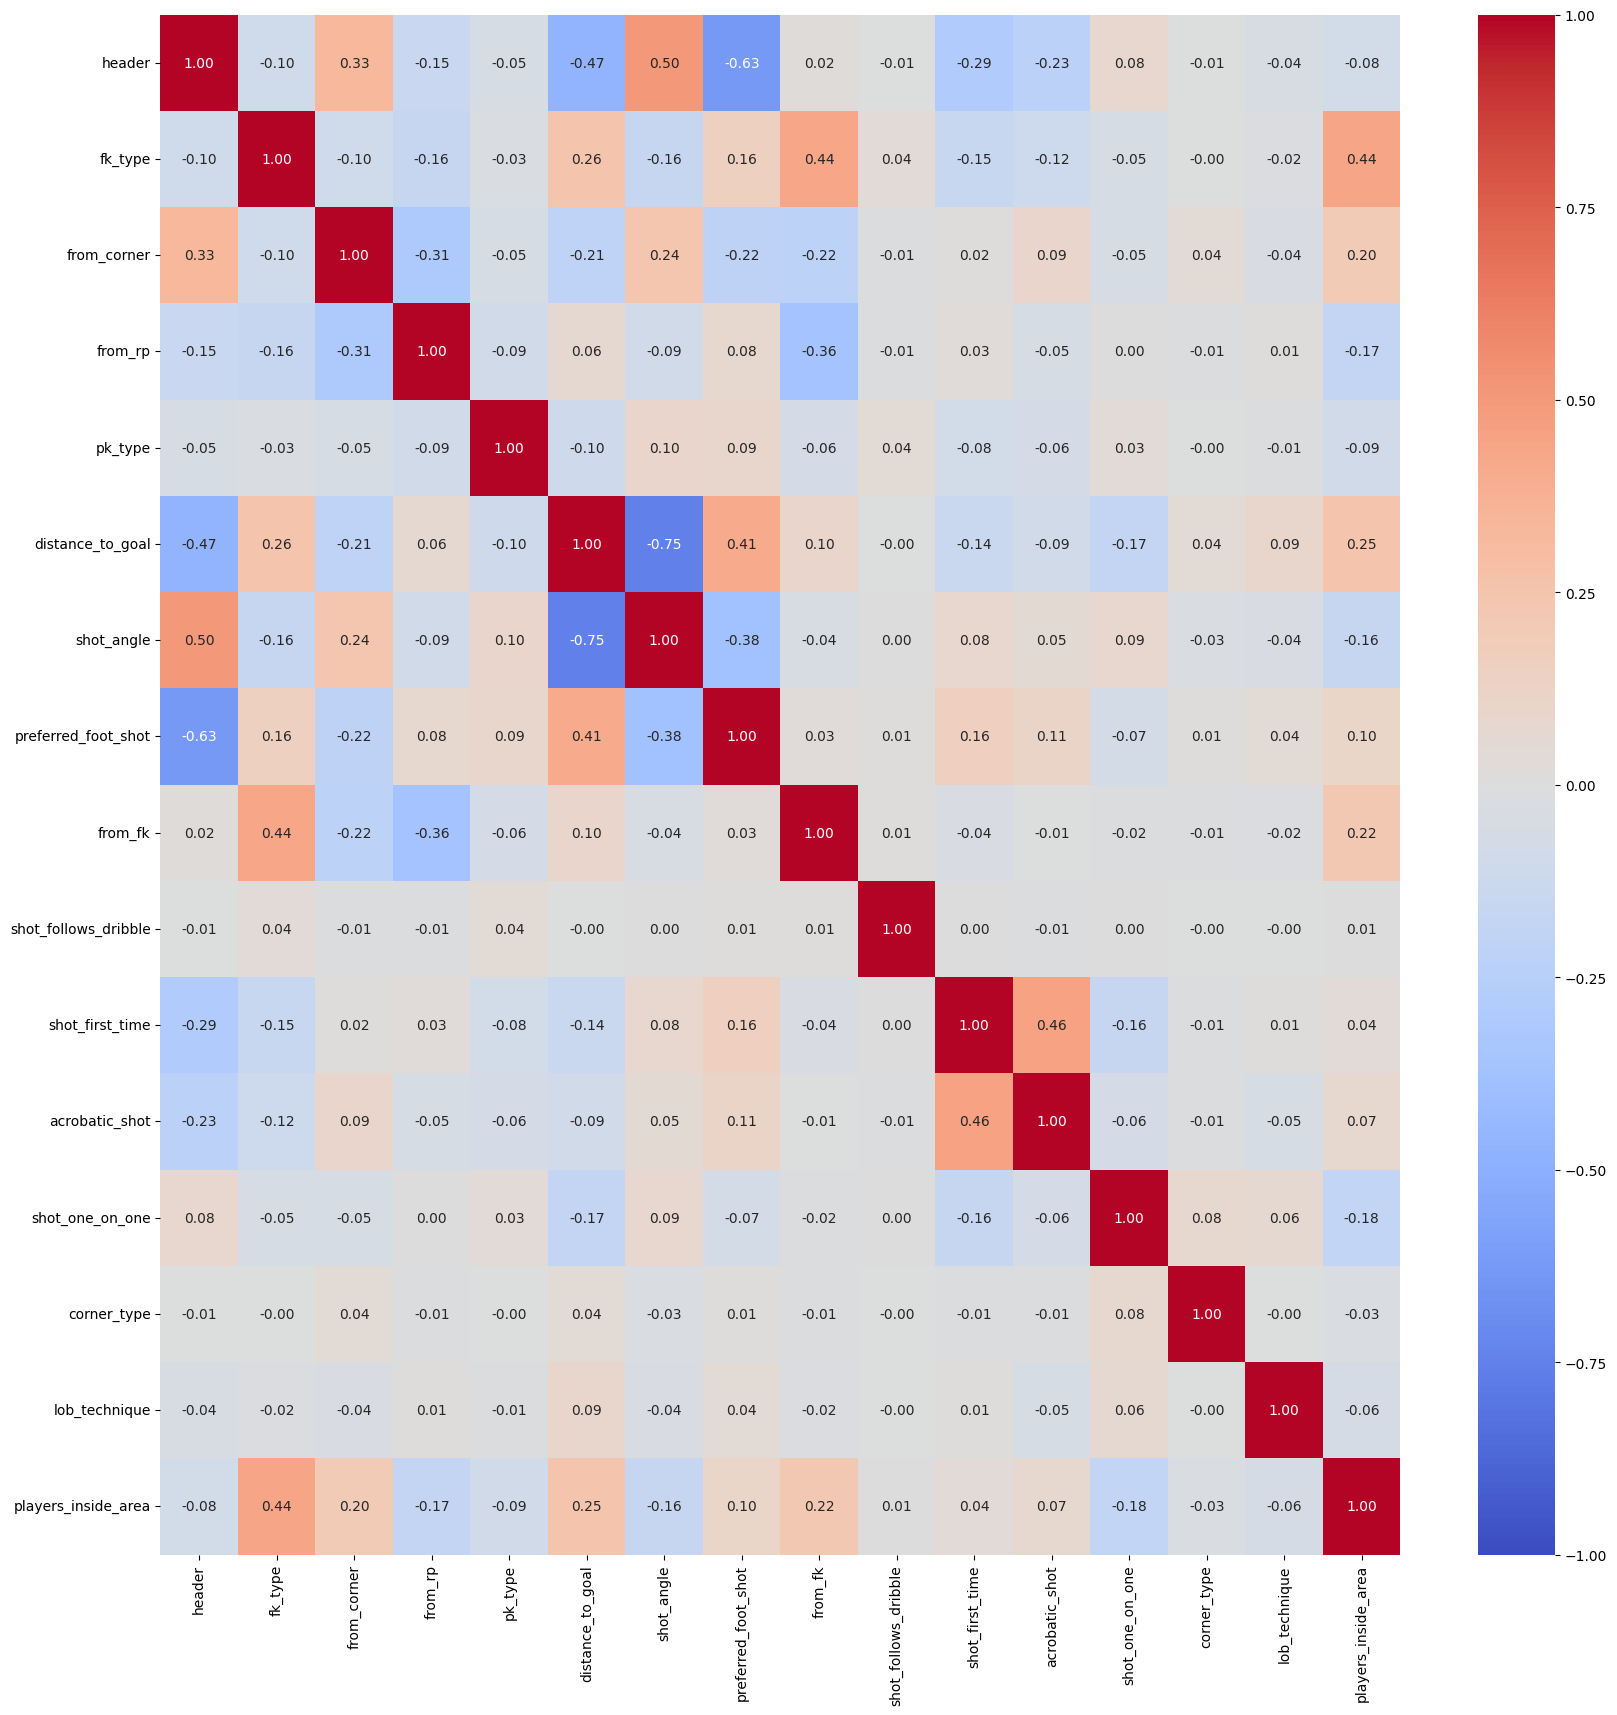

In [13]:
# correlation matrix between the features using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
cor = p[features].corr()
sns.heatmap(cor, annot=True, fmt=".2f",vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [14]:
shots= shots.withColumnRenamed('xG','shot_statsbomb_xg')

In [20]:
variables = ['id','player_id','shot_location_x','shot_location_y','distance_to_goal','shot_angle',
             'preferred_foot_shot','from_rp','from_fk','from_corner','header','corner_type','fk_type',
             'pk_type','lob_technique','shot_first_time','shot_one_on_one','shot_follows_dribble','players_inside_area',
             'acrobatic_shot','shot_statsbomb_xg','sb_prediction','goal']

In [16]:
shots.select(variables).union(shots_sb.select(variables)).count()

3755392

In [17]:
shots.count(), shots_sb.count()

(3693784, 61608)

In [29]:
shots = shots.withColumn('sb_prediction',
                    when(col('shot_statsbomb_xg')>=0.5,1).otherwise(0))

In [30]:
shots.select(variables).show(5)

+------+---------+------------------+------------------+----------------+------------------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+------------------+-------------+----+
|    id|player_id|   shot_location_x|   shot_location_y|distance_to_goal|        shot_angle|preferred_foot_shot|from_rp|from_fk|from_corner|header|corner_type|fk_type|pk_type|lob_technique|shot_first_time|shot_one_on_one|shot_follows_dribble|players_inside_area|acrobatic_shot| shot_statsbomb_xg|sb_prediction|goal|
+------+---------+------------------+------------------+----------------+------------------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+------------------+-------------+----+
|157392|     4299|107.16000366210938|54.240002441406

In [31]:
shots_sb.select(variables).show(5)

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+-----------------+-------------+----+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|from_rp|from_fk|from_corner|header|corner_type|fk_type|pk_type|lob_technique|shot_first_time|shot_one_on_one|shot_follows_dribble|players_inside_area|acrobatic_shot|shot_statsbomb_xg|sb_prediction|goal|
+--------------------+---------+---------------+---------------+----------------+----------+-------------------+-------+-------+-----------+------+-----------+-------+-------+-------------+---------------+---------------+--------------------+-------------------+--------------+-----------------+-------------+----+
|1088c144-e602-48d...|  23650.0|          101.9|       

In [32]:
final = shots.select(variables).union(shots_sb.select(variables))

In [33]:
final.write.csv("Dataset/shots_data.csv", header=True)

In [90]:
#shots_data
shots.show(5)

+------+---------+------------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+
|    id|player_id|   shot_location_x|   shot_location_y|lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|
+------+---------+------------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+-----

In [55]:
shots_sb.show(5)

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+-------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+------------+----+-------------+--------------+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|from_rp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|lob_technique|backheel_technique|diving_h_technique|under_pressure|shot_aerial_won|shot_first_time|shot_one_on_one|shot_open_goal|shot_follows_dribble|players_inside_area|shot_statsbomb_xg|shot_outcome|goal|sb_prediction|acrobatic_shot|
+--------------------+---------+---------------+---------------+--------------

In [91]:
shots = shots.withColumnRenamed('situation_FromCorner', 'from_corner')

In [92]:
# corner_type when the shot_location_x = 119.4 and shot_location_y = 79.6 or 0.4
shots = shots.withColumn("corner_type",
                 when((shots.shot_location_x == 119.4) &
                      ((shots.shot_location_y == 79.6) | (shots.shot_location_y == 0.4)), 1).otherwise(0))

In [94]:
shots_sb.filter(col("fk_type") == 1).groupBy('players_inside_area').count().show(20)

+-------------------+-----+
|players_inside_area|count|
+-------------------+-----+
|                 12|    1|
|                  1|  106|
|                 13|    2|
|                  6|  452|
|                  3|  487|
|                  5|  671|
|                  9|   30|
|                  4|  604|
|                  8|   82|
|                  7|  214|
|                 10|    9|
|                 11|    2|
|                  2|  258|
|                  0|   14|
+-------------------+-----+



In [29]:
# save the dataframe
shots.write.csv("understats/understat.csv", header=True, mode='overwrite')

## Part 2

In [99]:
shots = spark.read.csv("understat/understat.csv", header=True, inferSchema=True)
shots_sb = spark.read.csv("Data/Datas/shots.csv", header=True, inferSchema=True)

In [100]:
shots.count(), shots_sb.count()

(3693939, 61608)

In [102]:
# separating corners, free kicks, penalties from the shots dataframe
n_shots = shots.filter((col('corner_type') == 0) & (col('fk_type') == 0) & (col('pk_type') == 0))
sp_shots = shots.filter((col('corner_type') == 1) |(col('pk_type') == 1))
fk_shots = shots.filter(col('fk_type') == 1)

In [103]:
fk_shots = fk_shots.withColumn(
    "lob_technique",
    when(
        (col("fk_type") == 1) & (rand() < 0.0020463847203274215), 1
    ).otherwise(0))
sp_shots =sp_shots.withColumn(
    "lob_technique",
    when(
        (col("pk_type") == 1) & (rand() < 0.0031982942430703624), 1
    ).otherwise(0))
n_shots =n_shots.withColumn(
    "lob_technique",
    when(
        (col("shot_one_on_one") == 1) & (rand() < 0.03534563653425086), 1).otherwise(0))

In [104]:
shots = n_shots.union(sp_shots).union(fk_shots)
shots.count()

3693939

In [105]:
n_shots_sb = shots_sb.filter((col('corner_type') == 0) & (col('fk_type') == 0) & (col('pk_type') == 0)) # n_shots

In [106]:
X_values = [x for x in range(0,121,24)]
Y_values = [y for y in range(0,81,16)]
x_i = -1
y_i = -1
coo = {}
for X in range(len(X_values[:-1])):
    x_i += 1
    y_i = -1
    for Y in range(len(Y_values[:-1])):
        y_i += 1
        coo[f'region_{x_i}_{y_i}'] = [X_values[X], X_values[X+1], Y_values[Y], Y_values[Y+1]]
coo

{'region_0_0': [0, 24, 0, 16],
 'region_0_1': [0, 24, 16, 32],
 'region_0_2': [0, 24, 32, 48],
 'region_0_3': [0, 24, 48, 64],
 'region_0_4': [0, 24, 64, 80],
 'region_1_0': [24, 48, 0, 16],
 'region_1_1': [24, 48, 16, 32],
 'region_1_2': [24, 48, 32, 48],
 'region_1_3': [24, 48, 48, 64],
 'region_1_4': [24, 48, 64, 80],
 'region_2_0': [48, 72, 0, 16],
 'region_2_1': [48, 72, 16, 32],
 'region_2_2': [48, 72, 32, 48],
 'region_2_3': [48, 72, 48, 64],
 'region_2_4': [48, 72, 64, 80],
 'region_3_0': [72, 96, 0, 16],
 'region_3_1': [72, 96, 16, 32],
 'region_3_2': [72, 96, 32, 48],
 'region_3_3': [72, 96, 48, 64],
 'region_3_4': [72, 96, 64, 80],
 'region_4_0': [96, 120, 0, 16],
 'region_4_1': [96, 120, 16, 32],
 'region_4_2': [96, 120, 32, 48],
 'region_4_3': [96, 120, 48, 64],
 'region_4_4': [96, 120, 64, 80]}

In [107]:
# for each row in n_shots_sb, check if the shot_location_x and shot_location_y are in the region, if yes, assign the region to the row
for key, value in coo.items():
    n_shots_sb = n_shots_sb.withColumn(key,
                                       when((col('shot_location_x') >= value[0]) & (col('shot_location_x') <= value[1]) &
                                            (col('shot_location_y') >= value[2]) & (col('shot_location_y') <= value[3]), 1).otherwise(0))

In [108]:
from pyspark.sql.functions import lit

# create a column with None values
n_shots_sb = n_shots_sb.withColumn('region', lit(None))
# loop through the regions and if the shot is in the region, assign the region to the row, else keep the original value
for key, value in coo.items():
    n_shots_sb = n_shots_sb.withColumn('region',
                                       when(col(key) == 1, key).otherwise(col('region')))
for key, value in coo.items():
    n_shots_sb = n_shots_sb.drop(key)
n_shots_sb.show()

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+-------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+------------+----+-------------+----------+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|from_rp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|half_volley_technique|volley_technique|lob_technique|overhead_technique|backheel_technique|diving_h_technique|under_pressure|shot_aerial_won|shot_first_time|shot_one_on_one|shot_open_goal|shot_follows_dribble|players_inside_area|shot_statsbomb_xg|shot_outcome|g

In [109]:
from pyspark.sql.functions import avg, count

n_players = (n_shots_sb.groupBy('region', 'players_inside_area').agg(count("*").alias("count"),  # Count of rows
    avg("shot_statsbomb_xg").alias("avg_xG")  # Average of xG
    ).orderBy('region', 'players_inside_area'))
n_players.orderBy('region').show()

+----------+-------------------+-----+--------------------+
|    region|players_inside_area|count|              avg_xG|
+----------+-------------------+-----+--------------------+
|region_1_0|                  1|    1|         0.004407367|
|region_1_0|                  0|    2|        0.0114750425|
|region_1_1|                  0|    1|         0.012462552|
|region_1_1|                  1|    2|        0.0034739793|
|region_1_2|                  3|    1|        0.0034327148|
|region_1_2|                  2|    3|0.004180248066666666|
|region_1_2|                  1|    4|        0.0050863509|
|region_1_3|                  1|    1|        0.0036501586|
|region_1_4|                  0|    2|         0.013901768|
|region_2_0|                  1|    9|0.004827017955555556|
|region_2_0|                  0|    6|0.009814505366666665|
|region_2_0|                  2|    1|        0.0029691039|
|region_2_1|                  2|    8|     0.0035118366625|
|region_2_1|                  0|    3|0.

In [110]:
n_players = n_players.withColumnRenamed('count', 'n_shots')

In [111]:
total = n_shots_sb.groupBy('region').count().orderBy('region')

In [112]:
# left join the total dataframe with the n_players dataframe
n_players = n_players.join(total, 'region', 'left').orderBy('region')

In [113]:
# divide the count column by the total column as a percentage
n_players = n_players.withColumn('percentage',
                                 (col('n_shots') / col('count')).alias('percentage')).drop('count','n_shots')

In [114]:
np = n_players

In [115]:
n_players.show(5)

+----------+-------------------+------------+------------------+
|    region|players_inside_area|      avg_xG|        percentage|
+----------+-------------------+------------+------------------+
|region_1_0|                  1| 0.004407367|0.3333333333333333|
|region_1_0|                  0|0.0114750425|0.6666666666666666|
|region_1_1|                  0| 0.012462552|0.3333333333333333|
|region_1_1|                  1|0.0034739793|0.6666666666666666|
|region_1_2|                  3|0.0034327148|             0.125|
+----------+-------------------+------------+------------------+
only showing top 5 rows



In [116]:
b_shots = n_shots
for key, value in coo.items():
    b_shots = b_shots.withColumn(key,
                                       when((col('shot_location_x') >= value[0]) & (col('shot_location_x') <= value[1]) &
                                            (col('shot_location_y') >= value[2]) & (col('shot_location_y') <= value[3]), 1).otherwise(0))
b_shots = b_shots.withColumn('region', lit(None))
for key, value in coo.items():
    b_shots = b_shots.withColumn('region',
                                       when(col(key) == 1, key).otherwise(col('region')))
for key, value in coo.items():
    b_shots = b_shots.drop(key)
b_shots = b_shots.filter(col('shot_location_x')>24)
b_shots.orderBy('region').show(5)

+------+---------+------------------+------------------+------------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+-----------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+-------------+----------+
|    id|player_id|   shot_location_x|   shot_location_y|  lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|       shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|lob_technique|    region|
+------+---------+------------------+------------------+------------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------

In [117]:
from pyspark.sql.functions import monotonically_increasing_id, row_number, abs
from pyspark.sql.window import Window
import pyspark.sql.functions as F

n_players = n_players.withColumnRenamed("players_inside_area", "n_players_inside_area")

# Add a new incremental column to uniquely identify each row
b_shots = b_shots.withColumn("unique_id", monotonically_increasing_id())

# Join b_shots with n_players on region
joined_df = (
    b_shots.join(n_players, "region", "inner")
    .withColumn("xg_diff", F.abs(F.col("xG") - F.col("avg_xG")))  # Compute absolute difference
)

In [118]:
# Define a window for each unique row using `unique_id` and order by xg_diff
window_spec = Window.partitionBy("unique_id").orderBy("xg_diff")

In [119]:
# Get the closest match (row with the minimum xg_diff)
closest_match_df = (
    joined_df.withColumn("rank", F.row_number().over(window_spec))
    .filter(F.col("rank") == 1)  # Keep only the closest match
    .select("unique_id", "n_players_inside_area")  # Keep relevant columns
    .withColumnRenamed("n_players_inside_area", "players_inside_area")
)

In [120]:
# Join back to original b_shots to maintain all other columns and duplicates
final_df = b_shots.join(
    closest_match_df,
    "unique_id",
    "left"
).drop("unique_id")  # Remove the incremental column if not needed anymore

# Show the result
final_df.show()

+------+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+-------------+----------+-------------------+
|    id|player_id|   shot_location_x|   shot_location_y| lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|lob_technique|    region|players_inside_area|
+------+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+-------+-----------+-------

In [121]:
len(sp_shots.withColumn('players_inside_area',when(sp_shots.corner_type == 1, 0).otherwise(1)).columns)

28

In [122]:
c = sp_shots.withColumn('players_inside_area',when(sp_shots.corner_type == 1, 0).otherwise(1)).columns

In [123]:
df = final_df.select(c).union(sp_shots.withColumn('players_inside_area',when(sp_shots.corner_type == 1, 0).otherwise(1)).select(c))

## PART 3 : FK Shots

In [124]:
fk_shots_sb = shots_sb.filter(col('fk_type') == 1)
fk_shots_sb.count(), fk_shots.count()

(2932, 159335)

In [125]:
# for each row in n_shots_sb, check if the shot_location_x and shot_location_y are in the region, if yes, assign the region to the row
for key, value in coo.items():
    fk_shots_sb = fk_shots_sb.withColumn(key,
                                       when((col('shot_location_x') >= value[0]) & (col('shot_location_x') <= value[1]) &
                                            (col('shot_location_y') >= value[2]) & (col('shot_location_y') <= value[3]), 1).otherwise(0))

In [126]:
from pyspark.sql.functions import lit, avg, count

# create a column with None values
fk_shots_sb = fk_shots_sb.withColumn('region', lit(None))
# loop through the regions and if the shot is in the region, assign the region to the row, else keep the original value
for key, value in coo.items():
    fk_shots_sb = fk_shots_sb.withColumn('region',
                                       when(col(key) == 1, key).otherwise(col('region')))
for key, value in coo.items():
    fk_shots_sb = fk_shots_sb.drop(key)

n_players = (n_shots_sb.groupBy('region', 'players_inside_area').agg(count("*").alias("count"),  # Count of rows
    avg("shot_statsbomb_xg").alias("avg_xG")  # Average of xG
    ).orderBy('region', 'players_inside_area'))
n_players.orderBy('region',ascending=False).show()

+----------+-------------------+-----+--------------------+
|    region|players_inside_area|count|              avg_xG|
+----------+-------------------+-----+--------------------+
|region_4_4|                  2|   10|       0.00640160383|
|region_4_4|                  1|   33|0.007167558575757576|
|region_4_4|                  0|    8|        0.0116492005|
|region_4_4|                  3|    1|         0.006910697|
|region_4_3|                  5|  123| 0.03712746891463415|
|region_4_3|                  1| 5694| 0.07880574576629783|
|region_4_3|                  2| 3125|0.043372343326112006|
|region_4_3|                  6|   47|0.040243535000000004|
|region_4_3|                  9|    1|         0.016566036|
|region_4_3|                  4|  285| 0.04055711523438596|
|region_4_3|                  3|  845| 0.04179479312307693|
|region_4_3|                  7|    9| 0.04179767566666667|
|region_4_3|                  8|    8|0.028081416624999998|
|region_4_3|                  0|  316|  

In [127]:
n_players = n_players.withColumnRenamed('count', 'n_shots')
total = fk_shots_sb.groupBy('region').count().orderBy('region')
total.show(50)

+----------+-----+
|    region|count|
+----------+-----+
|region_2_0|    1|
|region_2_1|    4|
|region_2_2|    3|
|region_2_3|    1|
|region_2_4|    1|
|region_3_0|   13|
|region_3_1|  431|
|region_3_2|  969|
|region_3_3|  394|
|region_3_4|    6|
|region_4_0|   77|
|region_4_1|  392|
|region_4_2|  296|
|region_4_3|  308|
|region_4_4|   36|
+----------+-----+



In [128]:
n_players = n_players.join(total, 'region', 'left').orderBy('region')
# divide the count column by the total column as a percentage
n_players = n_players.withColumn('percentage',
                                 (col('n_shots') / col('count')).alias('percentage')).drop('count','n_shots')
np = n_players

In [129]:
n_players.show(6)

+----------+-------------------+--------------------+----------+
|    region|players_inside_area|              avg_xG|percentage|
+----------+-------------------+--------------------+----------+
|region_1_0|                  1|         0.004407367|      NULL|
|region_1_0|                  0|        0.0114750425|      NULL|
|region_1_1|                  0|         0.012462552|      NULL|
|region_1_1|                  1|        0.0034739793|      NULL|
|region_1_2|                  3|        0.0034327148|      NULL|
|region_1_2|                  2|0.004180248066666666|      NULL|
+----------+-------------------+--------------------+----------+
only showing top 6 rows



In [130]:
f_shots = fk_shots
for key, value in coo.items():
    f_shots = f_shots.withColumn(key,
                                       when((col('shot_location_x') >= value[0]) & (col('shot_location_x') <= value[1]) &
                                            (col('shot_location_y') >= value[2]) & (col('shot_location_y') <= value[3]), 1).otherwise(0))
f_shots = f_shots.withColumn('region', lit(None))
for key, value in coo.items():
    f_shots = f_shots.withColumn('region',
                                       when(col(key) == 1, key).otherwise(col('region')))
for key, value in coo.items():
    f_shots = f_shots.drop(key)
f_shots = f_shots.filter(col('shot_location_x')>48)
f_shots.orderBy('region').show(5)

+------+---------+------------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+-------------+----------+
|    id|player_id|   shot_location_x|   shot_location_y|lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|lob_technique|    region|
+------+---------+------------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+----------

In [131]:
from pyspark.sql.functions import monotonically_increasing_id, row_number, abs
from pyspark.sql.window import Window
import pyspark.sql.functions as F

n_players = n_players.withColumnRenamed("players_inside_area", "n_players_inside_area")

# Add a new incremental column to uniquely identify each row
f_shots = f_shots.withColumn("unique_id", monotonically_increasing_id())

# Join b_shots with n_players on region
joined_df = (
    f_shots.join(n_players, "region", "inner")
    .withColumn("xg_diff", F.abs(F.col("xG") - F.col("avg_xG")))  # Compute absolute difference
)

In [132]:
# Define a window for each unique row using `unique_id` and order by xg_diff
window_spec = Window.partitionBy("unique_id").orderBy("xg_diff")

In [133]:
# Get the closest match (row with the minimum xg_diff)
closest_match_fk = (
    joined_df.withColumn("rank", F.row_number().over(window_spec))
    .filter(F.col("rank") == 1)  # Keep only the closest match
    .select("unique_id", "n_players_inside_area")  # Keep relevant columns
    .withColumnRenamed("n_players_inside_area", "players_inside_area")
)

In [134]:
# Join back to original b_shots to maintain all other columns and duplicates
fk_df = f_shots.join(
    closest_match_fk,
    "unique_id",
    "left"
).drop("unique_id")  # Remove the incremental column if not needed anymore

# Show the result
fk_df.show()

+------+---------+-----------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+-------------+----------+-------------------+
|    id|player_id|  shot_location_x|   shot_location_y|lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|lob_technique|    region|players_inside_area|
+------+---------+-----------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-----

In [136]:
fk_df.select(df.columns).union(df).count()

3693784

In [ ]:
fk_df.select(df.columns).union(df).show()

+------+---------+-----------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+-------------+-------------------+
|    id|player_id|  shot_location_x|   shot_location_y|lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|lob_technique|players_inside_area|
+------+---------+-----------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+

In [137]:
dataframe_final = fk_df.select(c).union(df.select(c))

In [138]:
dfss = dataframe_final

In [139]:
dataframe_final.write.csv('understats/understat.csv', header=True)

In [140]:
dataframe_final.show()

+------+---------+-----------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+----+------------------+----------------+------------------+--------------+-------------------+-------+--------------------+---------------+--------------+---------------+-----------+-------------+-------------------+
|    id|player_id|  shot_location_x|   shot_location_y|lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|fk_type|from_corner|from_rp|pk_type|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|from_fk|shot_follows_dribble|shot_first_time|acrobatic_shot|shot_one_on_one|corner_type|lob_technique|players_inside_area|
+------+---------+-----------------+------------------+----------+------+-----------------+----------------------+------------------+-------+-----------+-------+-------+------------------+

## Model

In [60]:
import xG_preprocessing as pp

In [59]:
features = ['header','fk_type','from_corner','from_rp','pk_type','distance_to_goal','shot_angle','preferred_foot_shot',
            'from_fk','shot_follows_dribble','shot_first_time','acrobatic_shot','shot_one_on_one','corner_type',
            'lob_technique','players_inside_area']

In [61]:
train_data, test_data = pp.pre_training(final_df, features,0.7)

In [62]:
from xG_training import ModelTrainer

In [63]:
log_reg = ModelTrainer(train_data,test_data,model_type='logistic',max_iter=100)

25/01/29 00:34:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [64]:
from xG_evaluation import ModelEvaluation

In [ ]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')

In [68]:
predictions = predictions.withColumn('sb_prediction', when(col('xG') > 0.5, 1).otherwise(0))

In [69]:
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'xG','goal_probability',model_type='regression')

In [72]:
predictions.count()

1044913

In [66]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.1,
 'Precision': 61.33,
 'Recall': 12.45,
 'Sensitivity': 12.45,
 'Specificity': 99.09,
 'F1': 20.7,
 'FPR': 0.91,
 'FNR': 87.55}

In [70]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 97.43,
 'Precision': 88.76,
 'Recall': 44.47,
 'Sensitivity': 44.47,
 'Specificity': 99.75,
 'F1': 59.25,
 'FPR': 0.25,
 'FNR': 55.53}

In [71]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00551, 'RMSE': 0.07426, 'MAE': 0.04342, 'R2': 75.63}